In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmapF

import sys
import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

###  load weights, graph and mean file:

In [3]:
PATCH_SIZE = 100

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/end2end_hardmine_iter_20000.caffemodel'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/sodlt_deploy.prototxt'
#DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/end2end_regression_deploy.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/mean.npy'

mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 116.1987664    86.25564234   87.22195852]


### load image and groud truth probability map:

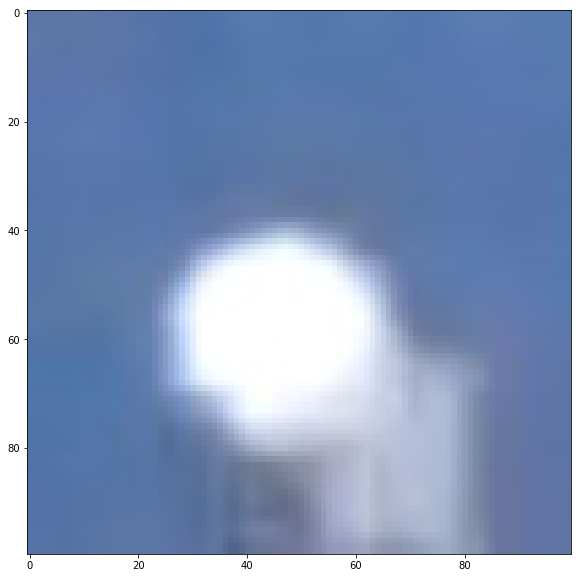

In [4]:
img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R027700.jpg'
prob_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R027700.prob.jpg'

image = caffe.io.load_image(img_name)
plt.imshow(image)

### forward the net, show predicted probability map:

9.43432e-07 0.999457


(-0.5, 49.5, 49.5, -0.5)

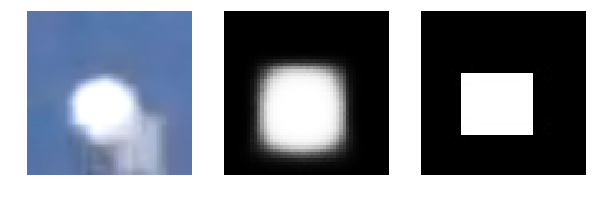

In [26]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

sodlt = net.blobs['sodlt_norm'].data[0][0]
print np.min(sodlt), np.max(sodlt)

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

### The roi layer predicts a bounding box from the probability map:

[ 11.  17.  37.  43.]
0.999457


(-0.5, 49.5, 49.5, -0.5)

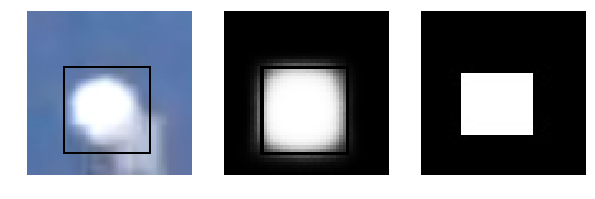

In [27]:
(x1,y1,x2,y2) = bbox = output['roi'][0]
prob_max = output['prob_max'][0]

print bbox
print prob_max

plt.subplot(1, 3, 1)
output_img = image.copy()
cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,0,255), 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
output_prob_map = sodlt.copy()
cv2.rectangle(output_prob_map, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(output_prob_map); plt.axis('off')

### show the probability map in 3D space:

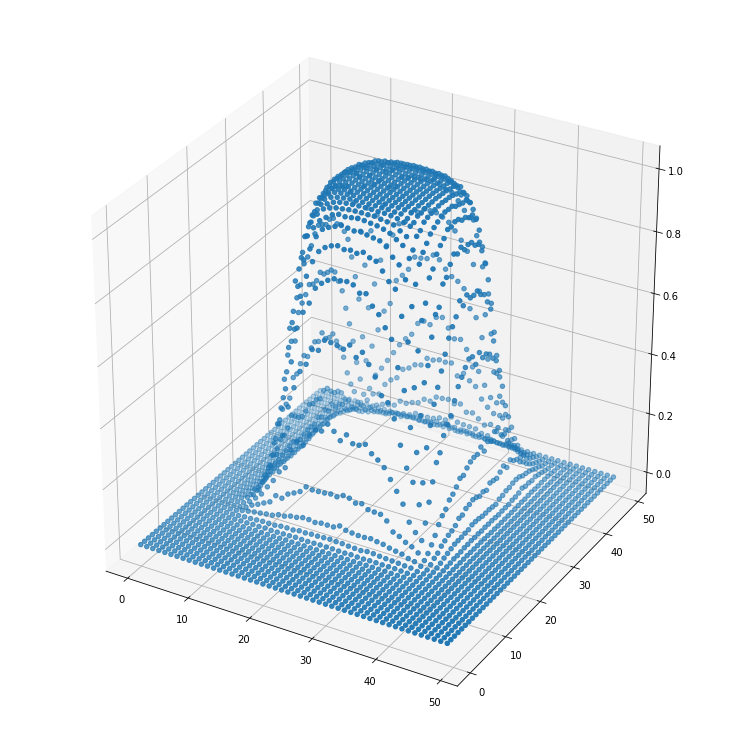

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
x = np.arange(0,50)
y = np.arange(0,50)
x, y = np.meshgrid(x,y)
ax.scatter(x,y,sodlt)
plt.show()

### Architecture of the SO-DLT network:

In [15]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 100, 100)
conv1	(1, 96, 23, 23)
pool1	(1, 96, 11, 11)
norm1	(1, 96, 11, 11)
conv2	(1, 256, 11, 11)
pool2	(1, 256, 5, 5)
norm2	(1, 256, 5, 5)
conv3	(1, 384, 5, 5)
conv4	(1, 384, 5, 5)
conv5	(1, 256, 5, 5)
pool5	(1, 1280)
sodlt_fc6	(1, 4096)
sodlt_fc7	(1, 1024)
sodlt_fc8	(1, 2500)
sodlt	(1, 1, 50, 50)
sodlt_norm	(1, 1, 50, 50)
roi	(1, 4)
prob_max	(1,)


In [16]:
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
sodlt_fc6	(4096, 1280) (4096,)
sodlt_fc7	(1024, 4096) (1024,)
sodlt_fc8	(2500, 1024) (2500,)


### Visualize some weights and data in the network

In [18]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

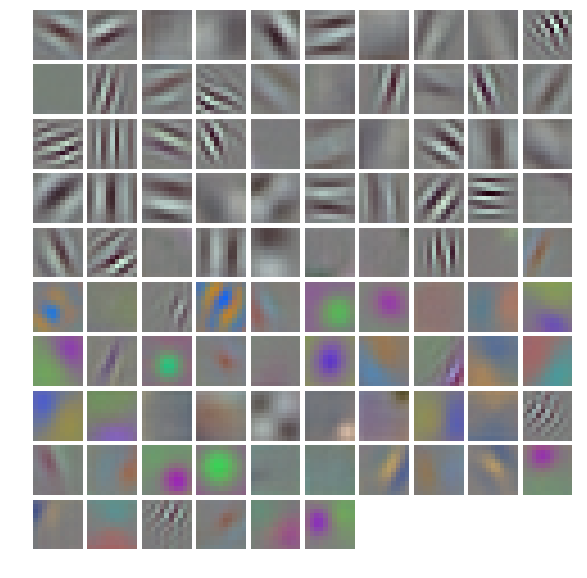

In [19]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

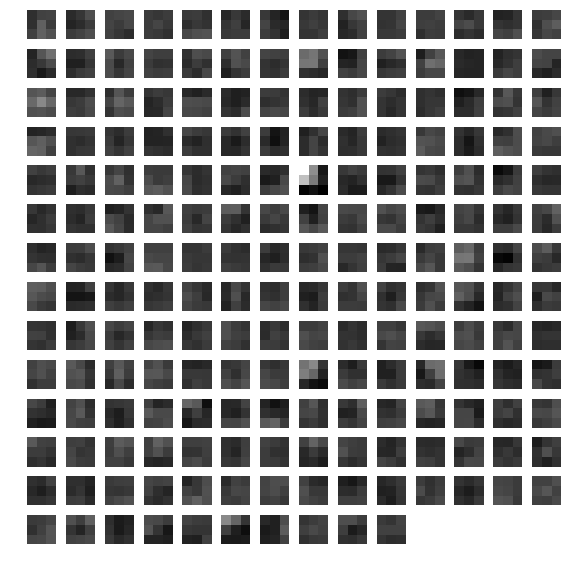

In [20]:
filters = net.params['conv4'][0].data
vis_square(filters[1])

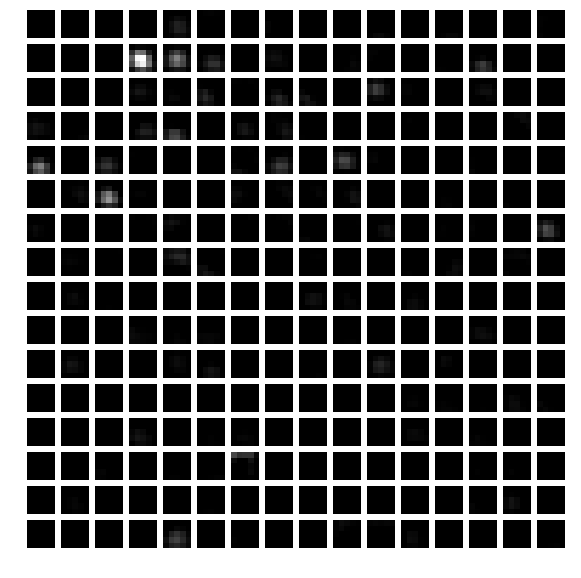

In [21]:
feat = net.blobs['conv5'].data[0]
vis_square(feat)

### The deprecated method of extracting bounding box from probability map:

(-0.5, 49.5, 49.5, -0.5)

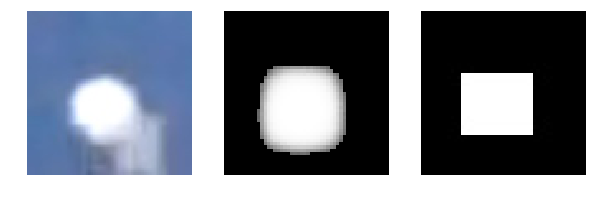

In [29]:
sodlt[sodlt<0.4] = 0

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

### Find contour:

In [31]:
sodlt_int = (sodlt*255).astype(np.uint8)
output_img = image.copy()
npaContours, npaHierarchy = cv2.findContours(sodlt_int.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for npaContour in npaContours:
    if cv2.contourArea(npaContour) > 10:
        [x,y,w,h] = cv2.boundingRect(npaContour)
        cv2.rectangle(output_img, (x*2,y*2), ((x+w)*2, (y+h)*2), (0,0,255), 1)

(-0.5, 99.5, 99.5, -0.5)

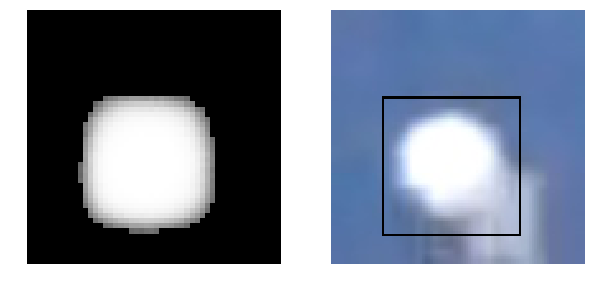

In [32]:
plt.subplot(1, 2, 1)
plt.imshow(sodlt); plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_img); plt.axis('off')

In [33]:
#speed
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 34.1 ms per loop
